In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


2025-12-29 09:20:50.990104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767000051.173626      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767000051.229788      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767000051.680701      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767000051.680753      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767000051.680756      55 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, matthews_corrcoef
)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight



In [3]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)


/kaggle/input
/kaggle/input/multi-cancer-detection-and-classification-dataset
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Skin_cancer
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Blood_cancer
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Lung_cancer


In [4]:
DATASET_DIR = "/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset"

In [5]:
os.listdir(DATASET_DIR)


['Skin_cancer', 'Blood_cancer', 'Lung_cancer']

In [6]:
IMG_SIZE = 224          
BATCH_SIZE = 16
EPOCHS = 15

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 7210 images belonging to 3 classes.
Found 1802 images belonging to 3 classes.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath='efficientnet_multicancer_best.keras',
        monitor='val_loss',
        save_best_only=True
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D,
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


IMG_SIZE = 224
NUM_CLASSES = 3

base_eff = EfficientNetB0(
    weights='imagenet',      # 🔥 IMPORTANT
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze backbone
base_eff.trainable = False

x = base_eff.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_eff.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1767000099.761550      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,383,398 (16.72 MB)

 Trainable params: 331,267 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [11]:
history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25
)


Epoch 1/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step - accuracy: 0.6905 - loss: 0.6834 - val_accuracy: 0.9850 - val_loss: 0.6747
Epoch 2/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 142s 316ms/step - accuracy: 0.6902 - loss: 0.6804 - val_accuracy: 0.9656 - val_loss: 0.6881
Epoch 3/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 144s 319ms/step - accuracy: 0.7229 - loss: 0.6278 - val_accuracy: 0.9612 - val_loss: 0.6006
Epoch 4/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 143s 317ms/step - accuracy: 0.7372 - loss: 0.6219 - val_accuracy: 0.9883 - val_loss: 0.5305
Epoch 5/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 147s 327ms/step - accuracy: 0.7461 - loss: 0.6079 - val_accuracy: 0.9612 - val_loss: 0.5116
Epoch 6/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 145s 322ms/step - accuracy: 0.7546 - loss: 0.5813 - val_accuracy: 0.9928 - val_loss: 0.4702
Epoch 7/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 149s 329ms/step - accuracy: 0.7407 - loss: 0.5835 - val_accuracy: 0.9945 - val_loss: 0.4803
Epoch 8/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.7664 -

**Fine tuning>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>**

In [13]:
model.trainable = True

for layer in model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8552 - loss: 0.3507

451/451 ━━━━━━━━━━━━━━━━━━━━ 185s 365ms/step - accuracy: 0.8552 - loss: 0.3506 - val_accuracy: 0.8851 - val_loss: 0.2958
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8686 - loss: 0.3234

451/451 ━━━━━━━━━━━━━━━━━━━━ 143s 317ms/step - accuracy: 0.8686 - loss: 0.3233 - val_accuracy: 0.8973 - val_loss: 0.2920
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.8793 - loss: 0.2997 - val_accuracy: 0.8724 - val_loss: 0.2982
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.8975 - loss: 0.2679 - val_accuracy: 0.8785 - val_loss: 0.2940
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8980 - loss: 0.2541

451/451 ━━━━━━━━━━━━━━━━━━━━ 143s 317ms/step - accuracy: 0.8980 - loss: 0.2541 - val_accuracy: 0.8651 - val_loss: 0.2776
Epoch 6/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 143s 317ms/step - accuracy: 0.8958 - loss: 0.2708 - val_accuracy: 0.8574 - val_loss: 0.3073
Epoch 7/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 143s 316ms/step - accuracy: 0.8867 - loss: 0.2827 - val_accuracy: 0.8402 - val_loss: 0.3406
Epoch 8/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 141s 313ms/step - accuracy: 0.8972 - loss: 0.2735 - val_accuracy: 0.8302 - val_loss: 0.3219
Epoch 9/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 138s 306ms/step - accuracy: 0.9043 - loss: 0.2567 - val_accuracy: 0.8241 - val_loss: 0.3282
Epoch 10/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 141s 313ms/step - accuracy: 0.9051 - loss: 0.2489 - val_accuracy: 0.8319 - val_loss: 0.3011


**ResNet50 (COMPARISON MODEL)**

In [15]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


res_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


res_train_gen = res_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

res_val_gen = res_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

base_res = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_res.trainable = False

x = base_res.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

res_model = Model(inputs=base_res.input, outputs=output)

res_model.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_res = res_model.fit(
    res_train_gen,
    validation_data=res_val_gen,
    epochs=25
)


Found 7210 images belonging to 3 classes.
Found 1802 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 84s 164ms/step - accuracy: 0.9890 - loss: 0.0347 - val_accuracy: 1.0000 - val_loss: 1.7524e-06
Epoch 2/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 70s 155ms/step - accuracy: 1.0000 - loss: 4.4692e-07 - val_accuracy: 1.0000 - val_loss: 2.1737e-06
Epoch 3/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 66s 147ms/step - accuracy: 1.0000 - loss: 1.1748e-07 - val_accuracy: 1.0000 - val_loss: 1.4088e-06
Epoch 4/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 69s 153ms/step - accuracy: 1.0000 - loss: 6.4587e-08 - val_accuracy: 1.0000 - val_loss: 1.1747e-06
Epoch 5/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 67s 147ms/step - accuracy: 1.0000 - loss: 6.4256e-08 - val_accuracy: 1.0000 - val_loss: 1.1069e-06
Epoch 6/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 65s 144ms/step - accuracy: 1.0000 - loss: 3.1850e-08 - val_accuracy: 1.0000 - val_loss: 9.4538e-07
Epoch 7/25
451/451 ━━━━━━━━━━━━━━━━

In [16]:
y_true = val_gen.classes
y_prob = model.predict(val_gen)
y_pred = np.argmax(y_prob, axis=1)


113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step


In [32]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[602   0   0]
 [  0 600   0]
 [  0 250 350]]


In [36]:
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')  # Sensitivity
f1 = f1_score(y_true, y_pred, average='macro')

print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1-score:", f1)


Precision: 0.9019607843137255
Recall (Sensitivity): 0.8611111111111112
F1-score: 0.8548094373865699


In [38]:

import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
specificity_per_class = []

for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

print("Specificity per class:", specificity_per_class)


Specificity per class: [np.float64(1.0), np.float64(0.7920133111480865), np.float64(1.0)]


In [41]:
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen’s Kappa:", kappa)


Cohen’s Kappa: 0.7918976348854397


In [42]:
mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)


MCC: 0.8158008280338664


In [44]:
y_true_bin = label_binarize(y_true, classes=[0,1,2])
roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
print("ROC–AUC:", roc_auc)


ROC–AUC: 0.9999579404695877


In [50]:
eff_acc = max(history_stage1.history['val_accuracy'])
res_acc = max(history_res.history['val_accuracy'])

print("EfficientNetB0 Val Acc:", eff_acc)
print("ResNet50 Val Acc:", res_acc)


EfficientNetB0 Val Acc: 0.9966703653335571
ResNet50 Val Acc: 1.0


In [47]:
model.save("efficientnet_multicancer_best.keras")

**Extended code for graphs>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>**

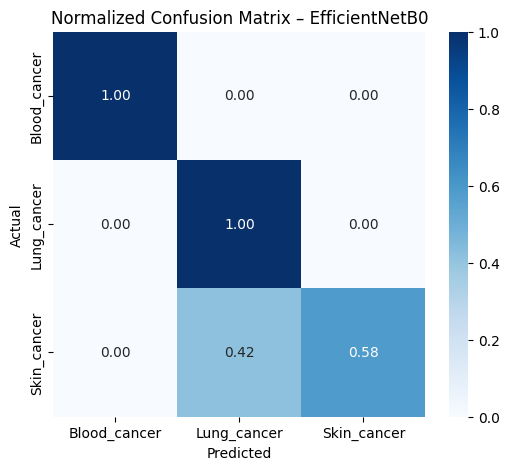

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CLASS_NAMES = ['Blood_cancer', 'Lung_cancer', 'Skin_cancer']

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            fmt='.2f')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix – EfficientNetB0")
plt.show()


In [62]:
roc_auc_macro = roc_auc_score(
    y_true_bin, y_prob,
    average='macro',
    multi_class='ovr'
)

print("Macro ROC–AUC:", roc_auc_macro)


Macro ROC–AUC: 0.9999579404695877


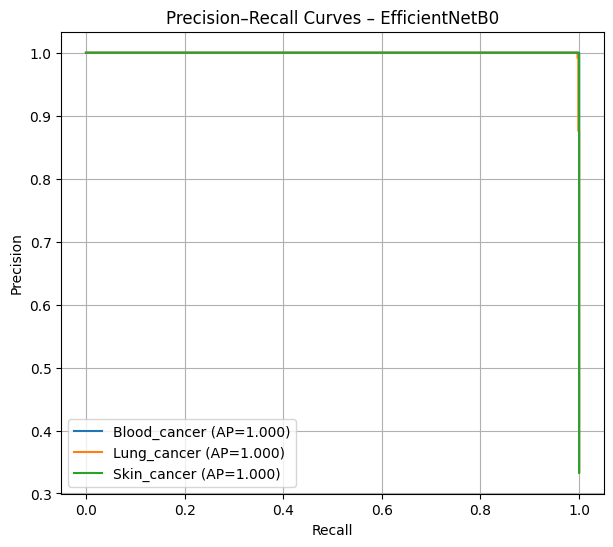

In [66]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7,6))

for i, class_name in enumerate(CLASS_NAMES):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i],
        y_prob[:, i]
    )
    ap = average_precision_score(
        y_true_bin[:, i],
        y_prob[:, i]
    )
    plt.plot(recall, precision, label=f"{class_name} (AP={ap:.3f})")



plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – EfficientNetB0")
plt.legend()
plt.grid(True)
plt.show()


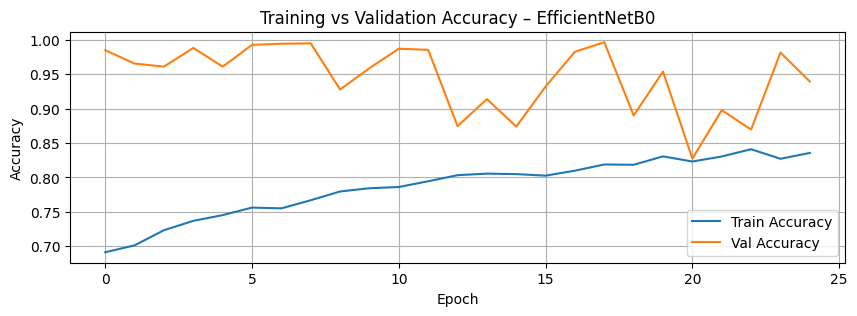

In [70]:
plt.figure(figsize=(10,3))
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy – EfficientNetB0")
plt.legend()
plt.grid(True)
plt.show()


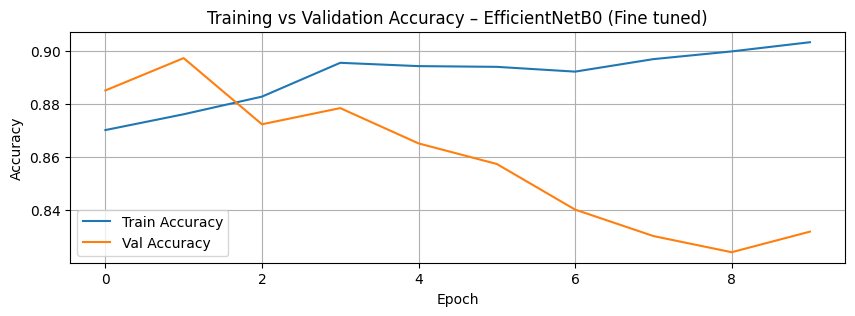

In [69]:
plt.figure(figsize=(10,3))
plt.plot(history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy – EfficientNetB0 (Fine tuned)")
plt.legend()
plt.grid(True)
plt.show()

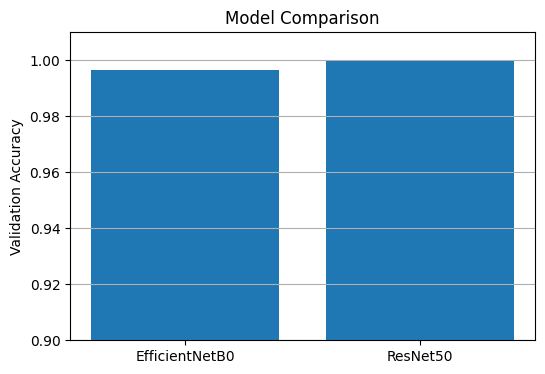

In [73]:
models = ['EfficientNetB0', 'ResNet50']
val_accs = [eff_acc, res_acc]

plt.figure(figsize=(6,4))
plt.bar(models, val_accs)
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison")
plt.ylim(0.9,1.01)
plt.grid(axis='y')
plt.show()


In [61]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1', 'Kappa', 'MCC', 'ROC-AUC'],
    'EfficientNetB0': [precision, recall, f1, kappa, mcc, roc_auc]
})

metrics_df


,Metric,EfficientNetB0
0,Precision,0.901961
1,Recall,0.861111
2,F1,0.854809
3,Kappa,0.791898
4,MCC,0.815801
5,ROC-AUC,0.999958


**...........................................Grad-CAM (Gradient-weighted Class Activation Mapping)............................................**

In [74]:
LAST_CONV_LAYER = "top_conv"


In [75]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [76]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [77]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array


In [78]:
def overlay_gradcam(img, heatmap, alpha=0.4):
    img = np.array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    return np.uint8(superimposed_img)


In [80]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)


/kaggle/input
/kaggle/input/multi-cancer-detection-and-classification-dataset
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Skin_cancer
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Blood_cancer
/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Lung_cancer


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


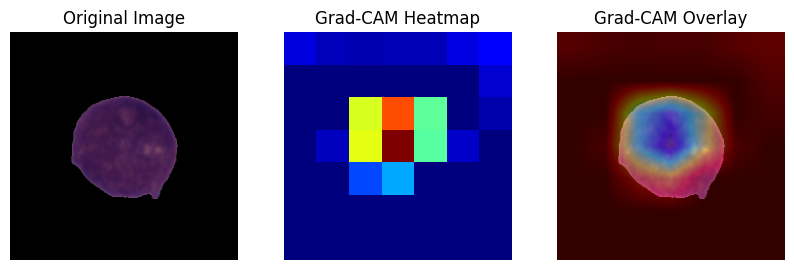

In [82]:
img_path = "/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Blood_cancer/UID_11_23_1_all.bmp"  # change path

img, img_array = load_preprocess_image(img_path)

heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="top_conv"
)

cam_img = overlay_gradcam(img, heatmap)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original ImageSS")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cam_img)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()


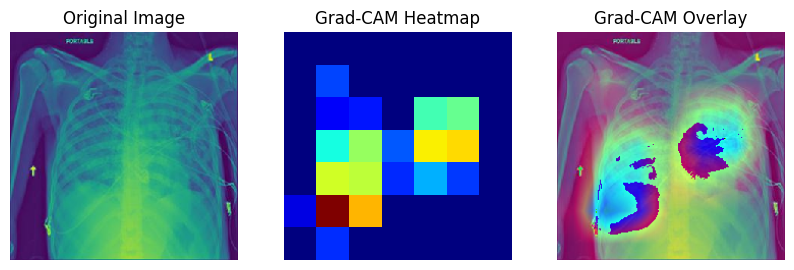

In [105]:
img_path = "/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Lung_cancer/1A (122).jpg"  # change path

img, img_array = load_preprocess_image(img_path)

heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="top_conv"
)

cam_img = overlay_gradcam(img, heatmap)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cam_img)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()


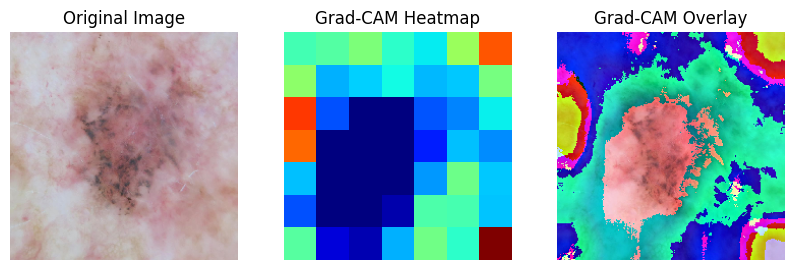

In [102]:
img_path = "/kaggle/input/multi-cancer-detection-and-classification-dataset/Multi_cancer_detection_and_classification_dataset/Skin_cancer/ISIC_0070505.jpg"  # change path

img, img_array = load_preprocess_image(img_path)

heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="top_conv"
)

cam_img = overlay_gradcam(img, heatmap)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cam_img)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()
